In [1]:
import numpy as np
import pandas as pd
import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy

In [2]:
#Transform all variable to Lie Operators
def MakeLieOperator(op):
    def CheckLieOperator(left,right):
        if not isinstance(right, LieOperator):
            other = LieOperator(right, left.indep_coords,left.indep_mom)
        
        return op(left,right)
    return CheckLieOperator

class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    #Initialize the operator
    def __init__(self, ham, indep_coords, indep_mom):
        self._ham = ham

        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
            
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
        self._indep_coords = indep_coords
        self._indep_mom = indep_mom

    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
    
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    @MakeLieOperator
    def __add__(self,other):
        return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    @MakeLieOperator
    def __radd__(self,other):
        return LieOperator(other.ham + self.ham,self.indep_coords,self.indep_mom)
        
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
    
    
    def LieOperatorMul(_lo1, _lo2):
        _ham1 = copy.deepcopy(_lo1.ham)
         
        if not isinstance(_lo2, LieOperator):
            _ham2 = copy.deepcopy(_lo2)
        else:
            _ham2 = copy.deepcopy(_lo2.ham)
            
        _coords = copy.deepcopy(_lo1.indep_coords)
        _mom = copy.deepcopy(_lo1.indep_mom)
        
        if S(_ham2).is_number:
            return LieOperator(S(0),_coords,_mom)
        elif S(_ham1).is_number:
            return LieOperator(S(_ham1)*_ham2, _coords,_mom)
        else:
            return _lo1.Poisson(_ham1,_ham2,_coords,_mom)
        
        
    
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if not isinstance(other, LieOperator):
            other = LieOperator(other, self.indep_coords, self.indep_mom)
        return other.LieOperatorMul(self)
        
#         if S(other).is_number:
#             return LieOperator(S(other)*self.ham, self.indep_coords,self.indep_mom)
#         else:
#             if not isinstance(other, LieOperator):
#                 other = LieOperator(other, self.indep_coords,self.indep_mom)
#             return other.Poisson(self)
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,_h1,_h2,_coords,_mom):
        hp = S(0)
#         print('In Poisson Bracket ---------------')
#         print(self, self.ham)
#         print(other, other.ham)
        for qi,pi in zip(_coords,_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            print('Breaks down after first derivative')
            hp -= _h1.diff(pi) * _h2.diff(qi)
            print('Second derivative was fine')
        return LieOperator(hp,_coords,_mom)

In [3]:
class LieMap(Expr):
    '''
    Defined algebra for the Lie Map:
    Inherits the structure of the Lie Operator
    Addition: Lie maps get added into a new Lie map
    Multiplication: Baker-Cambell-Hausdorff Formula is used 
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta, ExpPower, BCHPower
    ExpPower: cutoff for the exponential function
    BCHPower: cutoff for the Baker-Cambell-Hausdorff series
    
    For operations the higher power of the two elements will be selected
    '''
          
    #Initialize the operator
    def __init__(self, ham, indep_coords, indep_mom, ExpPower=6,BCHPower=2):
        self._ham = copy.deepcopy(ham)
        self._ExpN = copy.deepcopy(ExpPower)
        self._BCHN = copy.deepcopy(BCHPower)

        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
            
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
        self._indep_coords = indep_coords
        self._indep_mom = indep_mom

    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
#     #Define addition
#     def __add__(self,other):
#         if not self.__class__ == other.__class__:
#             print('Error: Both operators have to be Lie maps.')
#         else:
#             return LieMap(self.ham + other.ham, 
#                           self.indep_coords,
#                           self.indep_mom,
#                           max(self._ExpN,other._ExpN),
#                           max(self._BCHN,other._BCHN))

#     def __radd__(self,other):
#         if not self.__class__ == other.__class__:
#             print('Error: Both operators have to be Lie maps.')
#         else:
#             return LieMap(other.ham + self.ham, 
#                           self.indep_coords,
#                           self.indep_mom,
#                           max(self.ExpN,other.ExpN),
#                           max(self.BCHN,other.BCHN))
    
    
    #Define Multiplication
    '''
    Multiplication:
    1) Lie Map * Lie Map :  Application of the BCH series with cutoff
    2) Lie Map * Variable : Application of the exponential function cutoff
        to the variable
    '''
   
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        _ham1 = copy.deepcopy(self._ham)
        _ham2 = copy.deepcopy(other._ham)
        _coords = copy.deepcopy(self.indep_coords)
        _mom = copy.deepcopy(self.indep_mom)
        print('mul level ------------')
        print(_ham1)
        print(type(_ham1))
        print(_ham2)
        print(type(_ham2))
        print(_coords)
        print(type(_coords))
        print(_mom)
        print(type(_mom))
        print('end mul level ------------')
        global level_mul1
        global level_mul2
        level_mul1 = _ham1
        level_mul2 = _ham2
        
        if self.__class__ == other.__class__:
            return LieMap(self.BCH(_ham1,_ham2,_coords,_mom,max(self._BCHN,other._BCHN)),
                          self.indep_coords,
                          self.indep_mom,
                          max(self._ExpN,other._ExpN),
                          max(self._BCHN,other._BCHN))
        else:
            return self.exp(other,self._ExpN)
    
    
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if not isinstance(other, LieMap):
            print('Illegal operation: Right operator is not a Lie Map.')
            return
        return LieMap(other.BCH(self,max(self._BCHN,other._BCHN)),
                          self.indep_coords,
                          self.indep_mom,
                          max(self._ExpN,other._ExpN),
                          max(self._BCHN,other._BCHN))
    
    #Exponential map applied to Lie Operator
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        op1 = LieOperator(self.ham, self.indep_coords,self.indep_mom)
        
        if not isinstance(other, LieOperator):
            op2 = LieOperator(other,self.indep_coords,self.indep_mom)
        else:
            op2 = other
        
        if power > 0:
            hp = op1.__mul__(op2)
            
            for s in range(1,power):
                hp = op1.__mul__(hp)
                
        else:
            hp = op2
        
        return hp
    
    
    #Calculate the exponential map of the Lie operator to the input cutoff
    def exp(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom)       
    
    
    
    #BCH Multiplication
    def BCH(self,_ham1,_ham2,_coords,_mom,n):
        _s = S(0)
        
        _ham1 = copy.deepcopy(_ham1)
        _ham2 = copy.deepcopy(_ham2)
        _coords = copy.deepcopy(_coords)
        _mom = copy.deepcopy(_mom)
        
        global level_bch1
        global level_bch2
        
        level_bch1 = _ham1
        level_bch2 = _ham2
        
        print('BCH level ------------')
        print(_ham1)
        print(type(_ham1))
        print(_ham2)
        print(type(_ham2))
        print(_coords)
        print(type(_coords))
        print(_mom)
        print(type(_mom))
        print('end BCH level ------------')
        
        _op1 = LieOperator(_ham1,_coords,_mom)
        _op2 = LieOperator(_ham2,_coords,_mom)
        print((_op1.__mul__(_op2)).ham)
        
        for i in range(1,n+1):
            print('BCH Loop #',i)
            _s+= (self.translated(_ham1,_ham2,_coords,_mom, i)).ham
        return _s
    
    
    def NP(self,_n):
        _F = sympy.Matrix(np.zeros((_n+1,_n+1)))
        for i in range(_n+1):
            for j in range(_n+1):
                if (j-i)>=0:
                    _F[i,j] = sympy.Rational(1,int(fac(j-i))) # keep it rational !!!!



        _G = sympy.Matrix(np.zeros((_n+1,_n+1)))
        for i in range(_n+1):
            for j in range(_n+1):
                if (j-i)>=0:
                    if i==j:
                        sigprod = 1
                    else:
                        l = sympy.symbols('s{}:{}'.format(i,j))
                        sigprod = reduce(sympy.Mul,l)
                    _G[i,j] = sympy.Mul(sympy.Rational(1,int(np.math.factorial(j-i))),sigprod, evaluate=False)



        qthpower = sympy.Matrix(np.eye(_n+1))

        FGm1 = sympy.nsimplify(_F*_G - qthpower)

#         FGm1


        summ = 0

        for q in range(1,_n+1):
            qthpower = sympy.nsimplify(sympy.MatMul(qthpower, FGm1, evaluate=False))

            summ += sympy.nsimplify((-1)**(q-1)/q * qthpower)[0,_n] # q-1 because mathematica starts at 1 and not 0, there for sign change

        return sympy.expand(summ)

    def translated(self,_ham1,_ham2,_coords,_mom,n):
        l = sympy.symbols('s{}:{}'.format(0,n))
        temp = reduce(functools.partial(sympy.Mul,evaluate=False),[k*k for k in l])
        temp = sympy.expand(sympy.Mul(temp, self.NP(n), evaluate=False),evaluate=False)
        with sympy.evaluate(False):
            ln = sympy.symbols('r{}:{}'.format(0,n), commutative=False)
            for i, s in enumerate(l):
                temp = temp.subs(l[i],ln[i])
            for i in range(n):
                _f = sympy.Symbol('f',commutative=False)
                _g = sympy.Symbol('g',commutative=False)
                temp = temp.subs(ln[i]**3,_g)
                temp = temp.subs(ln[i]**2,_f)
                temp = temp.subs(_g**0,1)

            _ham1 = copy.deepcopy(_ham1)
            _ham2 = copy.deepcopy(_ham2)
            _coords = copy.deepcopy(_coords)
            _mom = copy.deepcopy(_mom)
            
            global level_translate1
            global level_translate2
            level_translate1 = _ham1
            level_translate2 = _ham2
            
            print('Translate level ------------')
            print(_ham1)
            print(type(_ham1))
            print(_ham2)
            print(type(_ham2))
            print(_coords)
            print(type(_coords))
            print(_mom)
            print(type(_mom))
            print('end Translate level ------------')
            
            global _op1
            global _op2
            _op1 = LieOperator(_ham1,_coords,_mom)
            _op2 = LieOperator(_ham2,_coords,_mom)
            
            print((_op1.LieOperatorMul(_op2)).ham)
            
#             print((_op1.__mul__(_op2)).ham)
            
            return 0
            #NEED TO WRITE THE FUNCTIONS TO RELATE NORMAL SYMBOLS TO LIE OPERATORS
            print('translated domain')
            print(_op1.ham)
            print(_op2.ham)
#             temp = temp.subs(_f,op1.ham)
#             temp = temp.subs(_g,op2.ham)
            temp = temp.replace(Mul, lambda *args: self.PoissonMultiplication(_op1,_op2,*args))
            print('ended substituting multiplication --------------')
            print(temp)
            print(type(temp))
            temp = temp.replace(Add, lambda *args: self.PoissonAddition(_op1,_op2,*args))
            
            if not isinstance(temp, LieOperator):
                temp = LieOperator(temp,self.indep_coords,self.indep_mom)
#             print('Checking temp')
#             print(temp)
#             print(type(temp))
#             temp = LieOperator(temp.ham.subs(f,op1.ham),self.indep_coords,self.indep_mom)
#             print('Checking temp after f subs')
#             print(temp)
#             print(type(temp))
#             temp = LieOperator(temp.ham.subs(g,op2.ham),self.indep_coords,self.indep_mom)
            
#             print('Checking temp after g subs')
            print('End of translated domain')
            
        return temp
    
    def PoissonMultiplication(self,_op1,_op2,*args):
        print('jumped into Poisson Multiplication')
        _f = sympy.Symbol('f',commutative=False)
        _g = sympy.Symbol('g',commutative=False)
#         if not isinstance(args[-1], LieOperator):
#             h = LieOperator(args[-1],self.indep_coords,self.indep_mom)
#         else:
#             h = args[-1]
        print('fine until assigning operators')
        if args[-1] == _f:
            _h = _op1
        elif args[-1] == _g:
            _h = _op2
        else:
            print('Expression does not start with an operator...')
            _h = 1
        
        print(args[-1])
        print(args[-1] == _f)
        print(args[-1] == _g)
               
        for op in args[-2::-1]:
            print("Looping thorugh args---------------")
            print(op)
            if S(op).is_number:
                print('Number recognized for', op)
                _h = op * _h
                print(_h)
                print(_h.ham)
            else:
#                 if not isinstance(op, LieOperator):
#                     op = LieOperator(op,self.indep_coords,self.indep_mom)
                print(op == _f)
                print(op == _g)
                print(_h)
                print(_op1)
                print(_op2)
                if op == _f:
                    print('f: for ', op, 'we multiply with ', _op1.ham ,_h.ham)
                    _h = _op1.__mul__(_h)
                elif op == _g:
                    print('g: for ', op, 'we multiply with ', _op2.ham , _h.ham)
                    _h = _op2.__mul__(_h)
                else:
                    print('We have more than just f and g, namely', op)
#                 h = h.Poisson(op)


        
#         h = n * h
        print(_h.ham)
        return _h.ham
    
    def PoissonAddition(self,op1,op2,*args):
        _h = 0
        
        _f = sympy.Symbol('f',commutative=False)
        _g = sympy.Symbol('g',commutative=False)
        
        if _f in args or _g in args:
            for op in args:
                if op == _f:
                    _h = _h + op1.ham
                elif op == _g:
                    _h = _h + op2.ham
                else:
                    print('Poisson addition op neither f nor g:')
                    print(op)
                    _h = _h + op
        else:
            for arg in args:
                _h = _h + arg
        
        return LieOperator(_h,self.indep_coords,self.indep_mom)

In [4]:
x, p, delta = sympy.symbols('x p d')
H1 = sympy.Function('H1', commutative=False)(x,p)
H2 = sympy.Function('H2', commutative=False)(x,p)
H3 = sympy.Function('H3', commutative=False)(x,p)
W = x**2 + p**2
Z = - sympy.sqrt((1+delta)**2 - p**2)
la = LieOperator(H1,x,p)
lb = LieOperator(H2,x,p)
lc = LieOperator(H3,x,p)
lz = LieOperator(W,x,p)
lw = LieOperator(Z,x,p)

ma = LieMap(H1,x,p,2,2)
mb = LieMap(H2,x,p,3,3)
mc = LieMap(H3,x,p,2,3)

mw = LieMap(W,x,p,2,2)
mz = LieMap(Z,x,p,2,2)

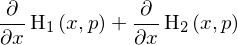

In [5]:
(H1 + H2).diff(x)

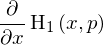

In [6]:
diff(H1,x)

In [7]:
type(lz.ham)

sympy.core.add.Add

Breaks down after first derivative
Second derivative was fine


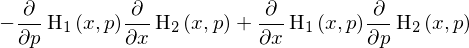

In [8]:
(la*lb).ham

Breaks down after first derivative
Second derivative was fine


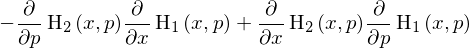

In [9]:
(lb*la).ham

In [10]:
(5*la).ham

Breaks down after first derivative
Second derivative was fine


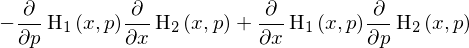

In [11]:
(la.Poisson(la.ham,lb.ham, la.indep_coords,la.indep_mom)).ham

Breaks down after first derivative
Second derivative was fine
2*p*x/sqrt(-p**2 + (d + 1)**2)
<class 'sympy.core.add.Add'>
<class 'sympy.core.add.Add'>


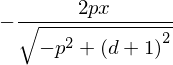

In [12]:
testa = LieOperator(mw.ham,mw.indep_coords,mw.indep_mom)
testb = LieOperator(mz.ham,mz.indep_coords,mz.indep_mom)

print((testa * testb).ham)
print(type(testa.ham))
print(type(mw.ham))
# mw.ham.diff(x)
# mw.ham
testb.ham.diff(x) * testa.ham.diff(p) - testa.ham.diff(x) * testb.ham.diff(p)

In [13]:
W.diff(p)

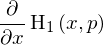

In [14]:
diff(H1,x)

In [15]:
type(mz.ham)

sympy.core.mul.Mul

In [16]:
# print(level_mul1 == level_bch1)
# print(level_bch1 == level_translate1)
# print(level_mul2 == level_bch2)
# print(level_bch2 == level_translate2)

In [19]:
(_op1.__mul__(_op2)).ham

AttributeError: 'Not' object has no attribute 'canonical'

In [18]:
mw*mz

mul level ------------
p**2 + x**2
<class 'sympy.core.add.Add'>
-sqrt(-p**2 + (d + 1)**2)
<class 'sympy.core.mul.Mul'>
[x]
<class 'list'>
[p]
<class 'list'>
end mul level ------------
BCH level ------------
p**2 + x**2
<class 'sympy.core.add.Add'>
-sqrt(-p**2 + (d + 1)**2)
<class 'sympy.core.mul.Mul'>
[x]
<class 'list'>
[p]
<class 'list'>
end BCH level ------------
Breaks down after first derivative
Second derivative was fine
2*p*x/sqrt(-p**2 + (d + 1)**2)
BCH Loop # 1
Translate level ------------
p**2 + x**2
<class 'sympy.core.add.Add'>
-sqrt(-p**2 + (d + 1)**2)
<class 'sympy.core.mul.Mul'>
[x]
<class 'list'>
[p]
<class 'list'>
end Translate level ------------


AttributeError: 'Not' object has no attribute 'canonical'

In [ ]:
(la*lb).ham

In [ ]:
la + lb

In [ ]:
2 + la

In [ ]:
la + 2

In [ ]:
(2*la).ham

In [ ]:
la*2

In [ ]:
(p*la).ham

In [ ]:
(la*p).ham

In [ ]:
# (ma + mb).ham

In [ ]:
# (mb + ma).ham

In [ ]:
# ma + x

In [ ]:
# x + ma

In [ ]:
(ma*x).ham

In [ ]:
(ma*g).ham

In [ ]:
(mw*x).ham

In [ ]:
(mz*x).ham

In [ ]:
g*ma